```
This software is part of GPU Ocean. 

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Reproducing CDKLM - Example 1

Reproducing results from the paper by Chertock et al. (2017
), where the CDKLM originally was proposed.

To make it work, go into  cdklm_kernel.cu and add an if (false) around the G-flux, and use $N = 2000$ instead of $N = 200$ with wall BC, or $N=1000$ with periodic BC. Periodic BC with $N=500$ is pretty good.

With the central upwind flux, $K$ varies a bit again even with $N= 1000$, but preserve $K=u=0$ for $N=2000$




In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from scipy import integrate

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic


In [2]:
%cuda_context_handler gpu_ctx

### Initial conditions

We are given flat bathymetry and 
\begin{equation}
K(x) \equiv 2, \quad u(x) = \equiv 0, \quad v(x) = \frac{2g}{f}x e^{-x^2}.
\end{equation}
We find $\eta(x)$ as:

\begin{equation}
\begin{split}
K(x) \equiv 0 &= g( \eta(x) - V(x) ) \\
&= g\left( \eta(x) - \int_{-\infty}^x \frac{f}{g} v(x') d x' \right) \\
&= g \left( \eta(x) + \int_{-\infty}^x (-2x') e^{-x'^2} d x' \right) \\
&= g \left( \eta(x) + e^{-x^2} \right) \\
\rightarrow \eta(x) &= \frac{2}{g} - e^{-x^2}
\end{split}
\end{equation}


### Boundary conditions
They use a zero order extrapolation. We use periodic.

In [3]:
nx = 1000
sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : nx, "ny" : 1,
    "dx" : 10/nx, "dy" : 10/nx,
    "dt" : 0,
    "theta" : 1.5,
    "f" : 10.0,
    "g" : 1.0,
    "r" : 0,
    "courant_number" : 0.5,
    #"rk_order": 3
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}


x_start = -5
x_end = 5
x = np.arange(x_start+0.5*sim_args["dx"], x_end, sim_args["dx"])
print(x[0], x[-1])


-4.995 4.994999999999787


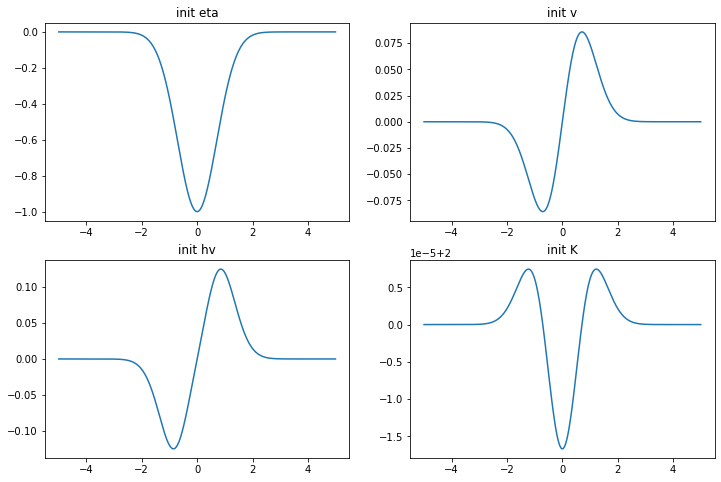

In [4]:

dataShape = (sim_args["ny"] + 4, 
             sim_args["nx"] + 4)

H_const = 2*sim_args["g"]
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_const
eta0 = np.zeros(dataShape, dtype=np.float64)
hu0 = np.zeros(dataShape, dtype=np.float64)
v0 = np.zeros(dataShape, dtype=np.float64)

eta0[2, 2:-2] = -np.exp(-x**2)
v0[2, 2:-2] = (2*sim_args["g"]/sim_args["f"])*x*np.exp(-x**2)

hv0 = v0*(eta0 + H_const)

fig = plt.figure(figsize=(12,8))
ax_eta = plt.subplot(2,2,1)
ax_eta.plot(x, eta0[2, 2:-2])
ax_eta.set_title("init eta")

ax_v = plt.subplot(2,2,2)
ax_v.plot(x, v0[2, 2:-2])
ax_v.set_title("init v")

ax_hv = plt.subplot(2,2,3)
ax_hv.plot(x, hv0[2, 2:-2])
ax_hv.set_title("init hv")

# Recompute K:
def computeK(eta, v, dx, g, f, H_const):
    eta = eta.astype(np.float64)
    v = v.astype(np.float64)
    V = np.cumsum(v)*dx
    V = integrate.cumtrapz(v, dx=dx, initial=0)
    return g*(eta + H_const - (f/g)*V)
K0 = computeK(eta0[2,2:-2], v0[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

ax_K = plt.subplot(2,2,4)
ax_K.plot(x, K0)
ax_K.set_title("init K")

data_args = {
    "H" : H, 
    "eta0" : eta0.astype(np.float32), 
    "hu0": hu0.astype(np.float32), 
    "hv0": hv0.astype(np.float32)
}

20.0


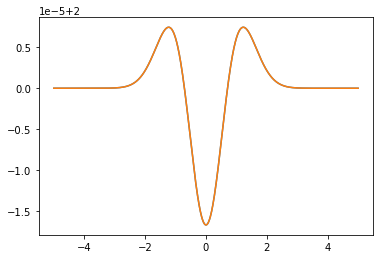

In [5]:
# Experiment with better eta0 and v0
nx_fine = 20000
dx_fine = 10/nx_fine
x_fine = np.arange(x_start+0.5*dx_fine, x_end, dx_fine)
eta0_fine = -np.exp(-x_fine**2)
v0_fine = (2*sim_args["g"]/sim_args["f"])*x_fine*np.exp(-x_fine**2)
K0_fine = computeK(eta0_fine, v0_fine, dx_fine, sim_args["g"], sim_args["f"], H_const)

print(nx_fine/nx)
rc_factor = int(nx_fine/nx)
eta0_rc = np.zeros_like(x)
v0_rc = np.zeros_like(x)
for i in range(len(eta0_rc)):
    eta0_rc[i] = np.sum(eta0_fine[i*rc_factor:(i+1)*rc_factor]/rc_factor)
    v0_rc[i]   = np.sum(  v0_fine[i*rc_factor:(i+1)*rc_factor]/rc_factor)

K0_rc = computeK(eta0_rc, v0_rc, sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

plt.plot(x, K0)
#plt.plot(x_fine, K0_fine)
plt.plot(x, K0_rc)

# Central upwinding

In [6]:
sim = CDKLM16.CDKLM16(**data_args, **sim_args, one_dimensional=True)
sim.step(200)
eta, hu, hv = sim.download(interior_domain_only=False)

v = hv/(eta + H_const)
u = hu/(eta + H_const)



C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


(1.9999, 2.0001)

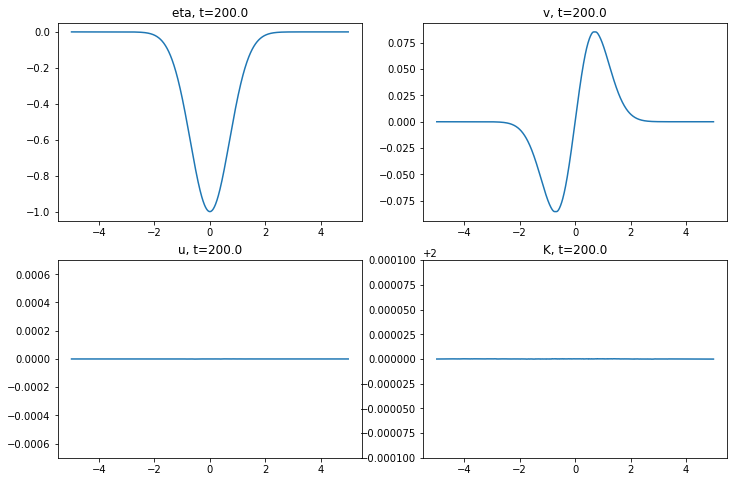

In [7]:
fig = plt.figure(figsize=(12,8))
ax_eta = plt.subplot(2,2,1)
ax_eta.plot(x, eta[2,2:-2])
ax_eta.set_title("eta, t="+str(sim.t))

ax_v = plt.subplot(2,2,2)
ax_v.plot(x, v[2, 2:-2])
ax_v.set_title("v, t="+str(sim.t))

ax_hv = plt.subplot(2,2,3)
ax_hv.plot(x, u[2, 2:-2])
ax_hv.set_title("u, t="+str(sim.t))
ax_hv.set_ylim([-7e-4, 7e-4])

K = computeK(eta[2,2:-2], v[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

ax_K = plt.subplot(2,2,4)
ax_K.plot(x, K)
ax_K.set_title("K, t="+str(sim.t))
ax_K.set_ylim([1.9999, 2.0001])


In [8]:
sim.dt, sim.nx

(0.0008833588217385113, 1000)

# Standard upwinding CDKLM

In [9]:
su_sim = CDKLM16.CDKLM16(**data_args, **sim_args, one_dimensional=True, central_upwind=False)
su_sim.step(200)
su_eta, su_hu, su_hv = su_sim.download(interior_domain_only=False)

su_v = su_hv/(su_eta + H_const)
su_u = su_hu/(su_eta + H_const)



C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


(1.9999, 2.0001)

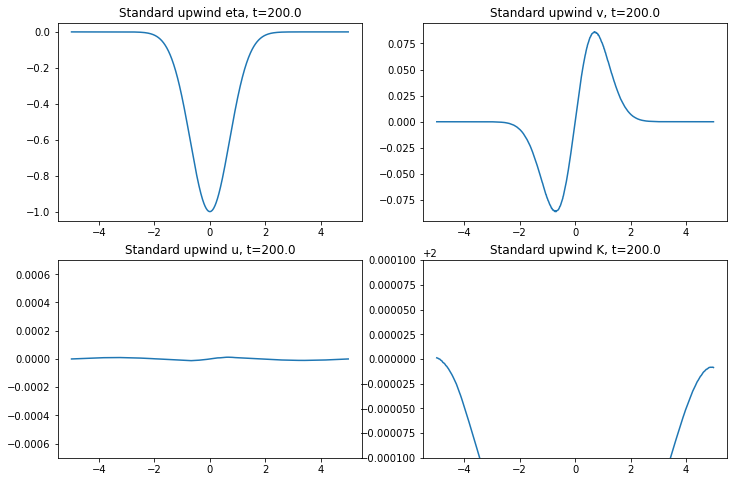

In [10]:
fig = plt.figure(figsize=(12,8))
ax_eta = plt.subplot(2,2,1)
ax_eta.plot(x, su_eta[2,2:-2])
ax_eta.set_title("Standard upwind eta, t="+str(su_sim.t))

ax_v = plt.subplot(2,2,2)
ax_v.plot(x, su_v[2, 2:-2])
ax_v.set_title("Standard upwind v, t="+str(su_sim.t))

ax_hv = plt.subplot(2,2,3)
ax_hv.plot(x, su_u[2, 2:-2])
ax_hv.set_title("Standard upwind u, t="+str(su_sim.t))
ax_hv.set_ylim([-7e-4, 7e-4])

su_K = computeK(su_eta[2,2:-2], su_v[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

ax_K = plt.subplot(2,2,4)
ax_K.plot(x, su_K)
ax_K.set_title("Standard upwind K, t="+str(su_sim.t))
ax_K.set_ylim([1.9999, 2.0001])


## Testing with KP

In [11]:
kp07_sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : nx, "ny" : 1,
    "dx" : 10/nx, "dy" : 10/nx,
    "dt" : sim.dt,
    "theta" : 1.5,
    "f" : 10.0,
    "g" : 1.0,
    "r" : 0,
    #"rk_order": 3
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}
    
kp_sim = KP07.KP07(**data_args, **kp07_sim_args)
kp_sim.step(200)
kp_eta, kp_hu, kp_hv = kp_sim.download(interior_domain_only=False)

kp_v = kp_hv/(kp_eta + H_const)
kp_u = kp_hu/(kp_eta + H_const)
# 


(1.9999, 2.0001)

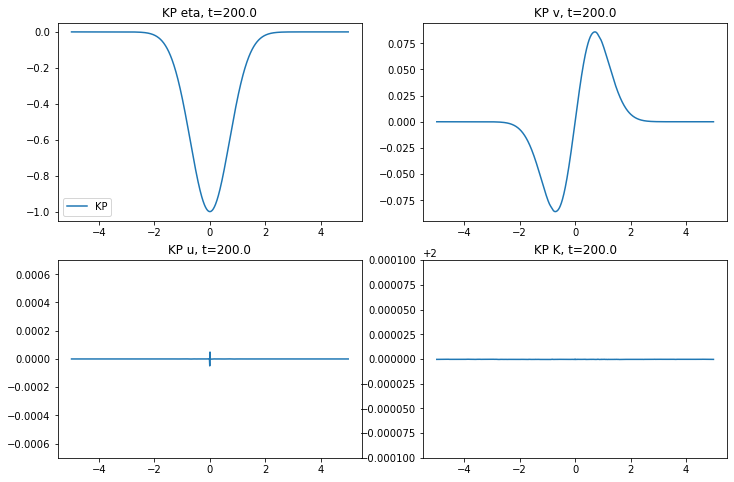

In [12]:
fig = plt.figure(figsize=(12,8))
ax_eta = plt.subplot(2,2,1)
ax_eta.plot(x, kp_eta[2,2:-2], label='KP')
ax_eta.set_title("KP eta, t="+str(sim.t))
ax_eta.legend()

ax_v = plt.subplot(2,2,2)
ax_v.plot(x, kp_v[2, 2:-2])
ax_v.set_title("KP v, t="+str(sim.t))

ax_hv = plt.subplot(2,2,3)
ax_hv.plot(x, kp_u[2, 2:-2])
ax_hv.set_title("KP u, t="+str(sim.t))
ax_hv.set_ylim([-7e-4, 7e-4])

kp_K = computeK(kp_eta[2,2:-2], kp_v[2, 2:-2], kp07_sim_args["dx"], kp07_sim_args["g"], kp07_sim_args["f"], H_const)

ax_K = plt.subplot(2,2,4)
ax_K.plot(x, kp_K)
ax_K.set_title("KP K, t="+str(sim.t))
ax_K.set_ylim([1.9999, 2.0001])


# Run all

In [13]:
def run_all(nx, T):
    sim_args = {
        "gpu_ctx" : gpu_ctx,
        "nx" : nx, "ny" : 1,
        "dx" : 10/nx, "dy" : 10/nx,
        "theta" : 1.5,
        "f" : 10.0,
        "g" : 1.0,
        "r" : 0,
        #"rk_order": 3
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }
    cdklm_args = {
        "courant_number" : 0.5,
        "dt" : 0,
        "one_dimensional": True
    }


    x_start = -5
    x_end = 5
    x = np.arange(x_start+0.5*sim_args["dx"], x_end, sim_args["dx"])
    

    dataShape = (sim_args["ny"] + 4, 
                sim_args["nx"] + 4)

    H_const = 2*sim_args["g"]
    H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_const
    eta0 = np.zeros(dataShape, dtype=np.float64)
    hu0 = np.zeros(dataShape, dtype=np.float64)
    v0 = np.zeros(dataShape, dtype=np.float64)

    eta0[2, 2:-2] = -np.exp(-x**2)
    v0[2, 2:-2] = (2*sim_args["g"]/sim_args["f"])*x*np.exp(-x**2)

    hv0 = v0*(eta0 + H_const)

    data_args = {
        "H" : H, 
        "eta0" : eta0.astype(np.float32), 
        "hu0": hu0.astype(np.float32), 
        "hv0": hv0.astype(np.float32)
    }

    cu_sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, )
    cu_sim.step(T)
    cu_eta, cu_hu, cu_hv = cu_sim.download(interior_domain_only=False)

    cu_v = cu_hv/(cu_eta + H_const)
    cu_u = cu_hu/(cu_eta + H_const)
    cu_K = computeK(cu_eta[2,2:-2], cu_v[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)


    su_sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, central_upwind=False)
    su_sim.step(T)
    su_eta, su_hu, su_hv = su_sim.download(interior_domain_only=False)

    su_v = su_hv/(su_eta + H_const)
    su_u = su_hu/(su_eta + H_const)
    su_K = computeK(su_eta[2,2:-2], su_v[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

    kp_args = {
        "dt": cu_sim.dt
    }
    kp_sim = KP07.KP07(**data_args, **sim_args, **kp_args)
    kp_sim.step(T)
    kp_eta, kp_hu, kp_hv = kp_sim.download(interior_domain_only=False)

    kp_v = kp_hv/(kp_eta + H_const)
    kp_u = kp_hu/(kp_eta + H_const)
    kp_K = computeK(kp_eta[2,2:-2], kp_v[2, 2:-2], sim_args["dx"], sim_args["g"], sim_args["f"], H_const)

    # Plotting
    fig = plt.figure(figsize=(12,8))
    ax_eta = plt.subplot(2,2,1)
    ax_eta.plot(x, cu_eta[2,2:-2], label='CU')
    ax_eta.plot(x, su_eta[2,2:-2], label='SU')
    ax_eta.plot(x, kp_eta[2,2:-2], label='KP')
    ax_eta.set_title("eta, t="+str(sim.t))
    ax_eta.legend()

    ax_v = plt.subplot(2,2,2)
    ax_v.plot(x, cu_v[2, 2:-2])
    ax_v.plot(x, su_v[2, 2:-2])
    ax_v.plot(x, kp_v[2, 2:-2])
    ax_v.set_title("v, t="+str(sim.t))

    ax_hv = plt.subplot(2,2,3)
    ax_hv.plot(x, cu_u[2, 2:-2])
    ax_hv.plot(x, su_u[2, 2:-2])
    ax_hv.plot(x, kp_u[2, 2:-2])
    ax_hv.set_title("u, t="+str(sim.t))
    ax_hv.set_ylim([-7e-4, 7e-4])

    ax_K = plt.subplot(2,2,4)
    ax_K.plot(x, cu_K)
    ax_K.plot(x, su_K)
    ax_K.plot(x, kp_K)
    ax_K.set_title("K, t="+str(sim.t))
    ax_K.set_ylim([1.9999, 2.0001])

    plt.suptitle("NX = "+ str(nx) + ", T = " + str(T))

        

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


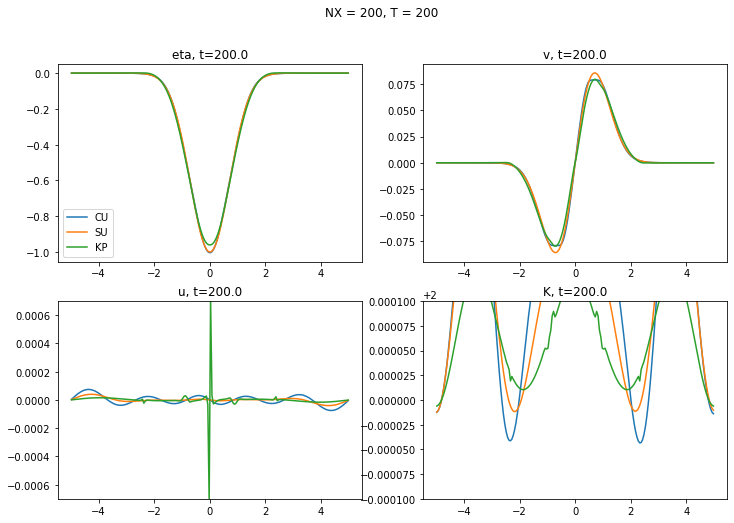

In [14]:
run_all(200, 200)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


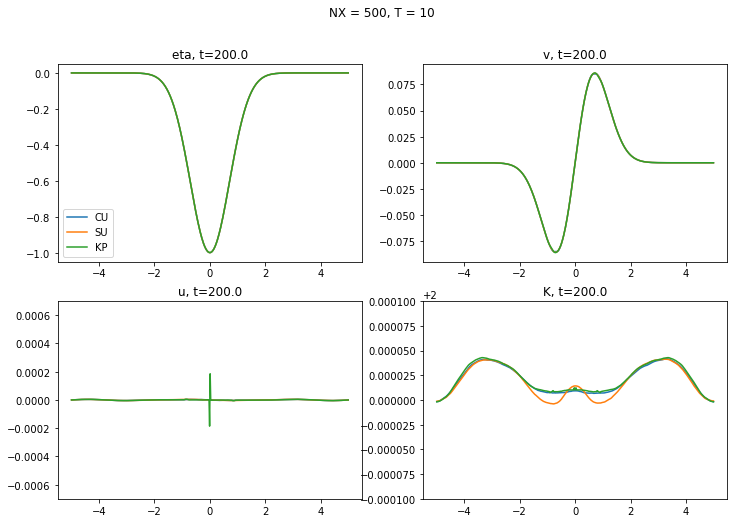

In [15]:
run_all(500, 10)

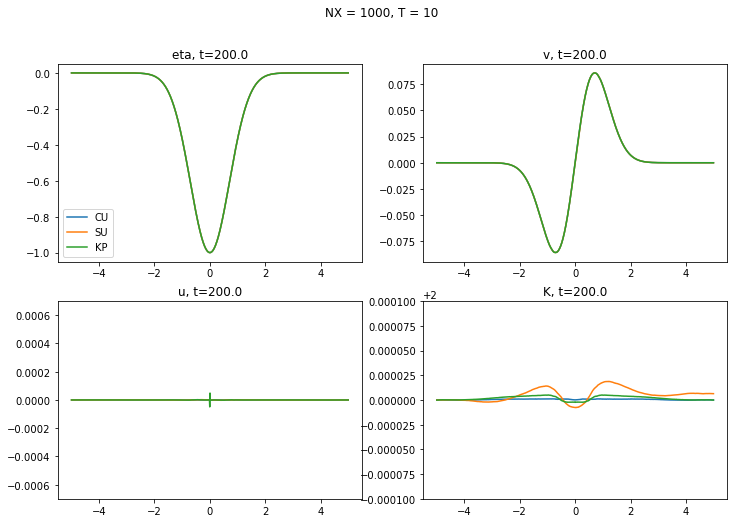

In [16]:
run_all(1000, 10)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


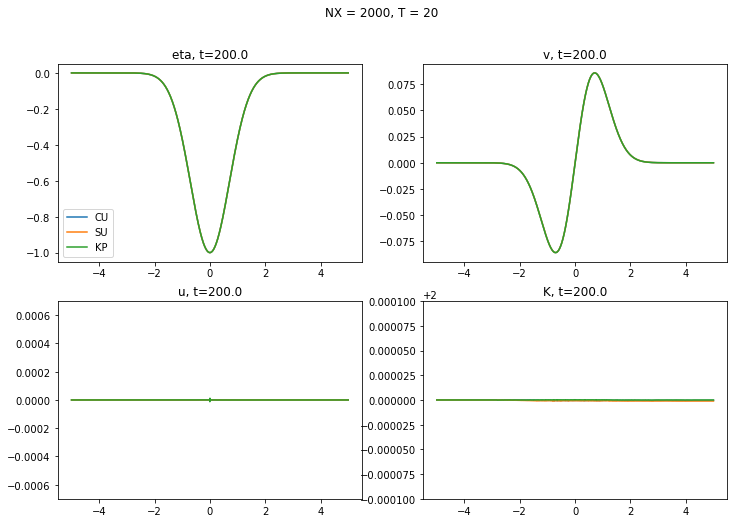

In [17]:
run_all(2000, 20)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


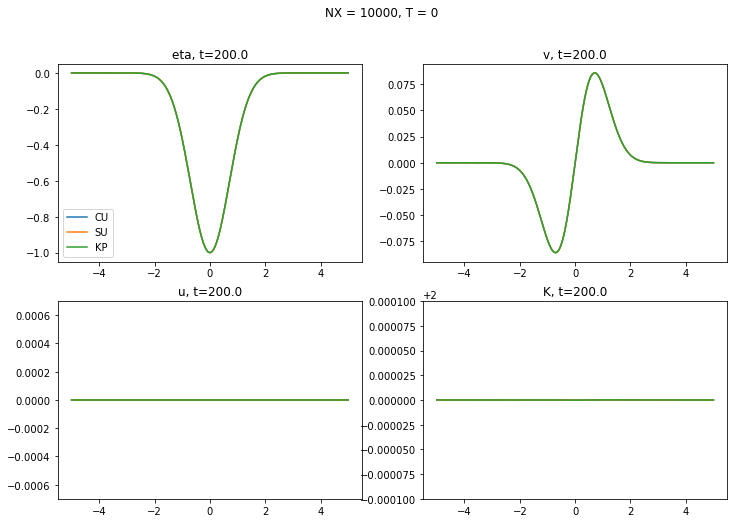

In [18]:
run_all(10000, 0)